# **CHECKPOINT 5: NATURAL LANGUAGE PROCESSING**
### ***DATA PIRATES***

> Kavya Jaganathan, Clarissa Cheam and Ayushi Mishra





**Overview**
> In this checkpoint we explore the text content available in the tables data_attachmentnarrative and data_allegation. We study both these tables since data_attachmentnarrative table's text content gives an account of the allegation, along with the victim perspective in terms of words uttered by the accused to them, tone/demeanor of accused that the observed, etc. whereas the data_allegation table's text content gives a report written by an officer without much of the victim's direct words.

**The question we hope to answer:**

What was the sentiment in the CPDB complaint data pre major reforms ( before 2016 ) and post major reforms?

**Note: Major reforms here indicate reforms like COPA and introduction of TRR**




**Installing packages**

In [ ]:
#@title
# Install and suppress output
%%capture
!pip install texthero vaderSentiment sidetable nltk pyldavis;

# import environmentals
import os
from pprint import pprint


import pyLDAvis
import pyLDAvis.gensim_models as gensim

# import text processing libraries
import texthero as hero
from texthero import preprocessing as pp
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords

import spacy

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# import sentiment analysis libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import ML libraries
import sklearn
from sklearn.cluster import MiniBatchKMeans as mb
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
from sklearn_pandas import DataFrameMapper

# import data structure libraries
import sidetable
import pandas as pd
import numpy as np

# import visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px

#@title
# Set function objects
analyzer = SentimentIntensityAnalyzer()
# Configure environment
pd.set_option('display.max_columns', None)

**Connecting to CPDB database**

In [ ]:
#@title
import psycopg2

conn = psycopg2.connect(
    host="codd04.research.northwestern.edu",
    port = "5433",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI")
cursor = conn.cursor()

## **FOR DATA ATTACHMENT NARRATIVE TABLE**

**Getting data and converting to dataframe**

In [ ]:
#@title Saving the desired table output 
complaint="select attachment_id,column_name,data_attachmentnarrative.text_content,allegation_id, substring(cast(incident_date as text),0,11) as incident_date from data_attachmentnarrative, data_attachmentfile, data_allegation where attachment_id = data_attachmentfile.id and allegation_id is not null and column_name not like 'Finding' and allegation_id = data_allegation.crid order by substring(cast(incident_date as text),0,11);"
#complaint="select * from data_attachmentnarrative"
#converting to a dataframe
cursor.execute(complaint)
complaint_n = cursor.fetchall()
print("shape is: " + str(len(complaint_n)))

df_complaint = pd.DataFrame(complaint_n)
colnames = [desc[0] for desc in cursor.description]
df_complaint.columns = colnames

#dropping null entries of start date
#df_complaint=df_complaint.dropna(subset=['incident_date'])

print(df_complaint.shape)

shape is: 31555
(31555, 5)


In [ ]:
#@title
df_complaint['incident_date']= pd.to_datetime(df_complaint['incident_date'])

In [ ]:
#@title
df_complaint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31555 entries, 0 to 31554
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   attachment_id  31555 non-null  int64         
 1   column_name    31555 non-null  object        
 2   text_content   31555 non-null  object        
 3   allegation_id  31555 non-null  object        
 4   incident_date  31275 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.2+ MB


In [ ]:
#@title Checking our dataframe output
print(df_complaint.head())

   attachment_id                  column_name  \
0          51827  Initial / Intake Allegation   
1          51827                   Allegation   
2          51827  Initial / Intake Allegation   
3          31479  Initial / Intake Allegation   
4          31462  Initial / Intake Allegation   

                                        text_content allegation_id  \
0  The complainant alleges that the accused\nDepa...       1056174   
1        Victim/Offender\nSituation Aty Weapon Types       1056174   
2   The complainant alleges that the accused\nDep...       1056174   
3  The complainant alleged that the accused\noffi...       1051104   
4   The complainant alleged that the accused\noff...       1051104   

  incident_date  
0    1971-02-28  
1    1971-02-28  
2    1971-02-28  
3    1982-12-31  
4    1982-12-31  


**Applying pre processing to clean text with Text Hero**

In [ ]:
#@title
def cleaner(df):
    pipeline = [pp.fillna
                , pp.remove_digits
                , pp.lowercase
                , pp.remove_punctuation
                , pp.remove_diacritics
                , pp.remove_stopwords
                , pp.remove_whitespace
                , pp.stem
                ]
    df['text_content'] = hero.clean(df['text_content'], pipeline=pipeline)
    return df
df_clean = cleaner(df_complaint)

**NOTE: We remove all rows where column_name is FINDINGS as the text content is sparse and doesn't contribute to analysis**

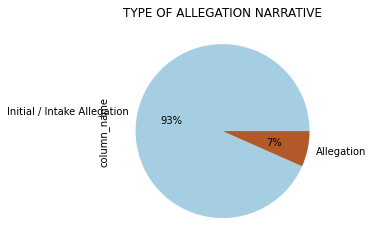

In [ ]:
#@title
#Plotting the column_name aka type of allegation narrative types
p=df_clean.column_name.value_counts()
p.plot(kind='pie', autopct='%1.0f%%',title='TYPE OF ALLEGATION NARRATIVE', colormap='Paired')

**Apply sentiment analysis to cleaned data with Vader**


>Reference: https://medium.com/swlh/simple-sentiment-analysis-for-nlp-beginners-and-everyone-else-using-vader-and-textblob-728da3dbe33d

In [ ]:
#@title 
df = df_clean
df['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df['text_content']]
df['neg'] = [analyzer.polarity_scores(v)['neg'] for v in df['text_content']]
df['neu'] = [analyzer.polarity_scores(v)['neu'] for v in df['text_content']]
df['pos'] = [analyzer.polarity_scores(v)['pos'] for v in df['text_content']]
print(df.head(2))

   attachment_id                  column_name  \
0          51827  Initial / Intake Allegation   
1          51827                   Allegation   

                                        text_content allegation_id  \
0  complain alleg accus depart member fail conduc...       1056174   
1               victim offend situat ati weapon type       1056174   

  incident_date  compound    neg    neu  pos  
0    1971-02-28   -0.8442  0.503  0.497  0.0  
1    1971-02-28   -0.6705  0.684  0.316  0.0  


**Time Series complaint analysis using incident date**

In [ ]:
#@title
#to set the datetime for plotting
from datetime import datetime
time_now = datetime.now()

import pytz

               100_neg  100_pos  100_neu  100_compound
incident_date                                         
2012-01-13      0.1630   0.0000   0.8370     -0.542300
2011-11-07      0.2265   0.0000   0.7735     -0.542300
2013-10-20      0.2240   0.0000   0.7760     -0.681767
2012-07-19      0.1950   0.0000   0.8050     -0.731500
2012-10-31      0.1624   0.0116   0.8260     -0.539940


<Figure size 432x288 with 0 Axes>

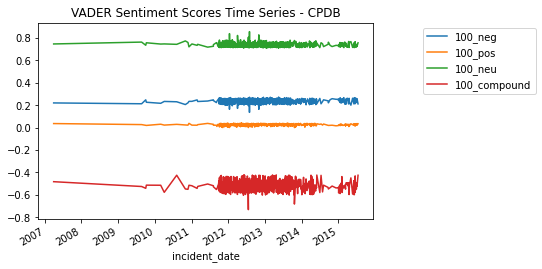

In [ ]:
#@title
df_timeseries = df[['incident_date', 'compound', 'neg', 'neu', 'pos']].copy()
df_timeseries = df_timeseries.sample(n=1000, random_state=42)
df_timeseries.set_index('incident_date', inplace=True)

df_timeseries['100_neg'] = df_timeseries.neg.rolling(100, min_periods=1).mean()
df_timeseries['100_pos'] = df_timeseries.pos.rolling(100, min_periods=1).mean()
df_timeseries['100_neu'] = df_timeseries.neu.rolling(100, min_periods=1).mean()
df_timeseries['100_compound'] = df_timeseries.compound.rolling(100, min_periods=1).mean()
df_plot=df_timeseries[['100_neg','100_pos', '100_neu', '100_compound']]
print(df_plot.head())

plt.figure()
df_plot.plot(title='VADER Sentiment Scores Time Series - CPDB', legend=False)
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))
plt.show()

**Analysis**

> Before analyzing the time series graph some of the terminology to be aware of:

1. **Sentiment:** Attitude to a certain situation or event
2. **Compound:** It is a ‘normalized, weighted composite score computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).

In the data_attachmentnarrative table, the text content gives an account of the allegation along with the victim perspective in terms of words uttered by the accused to them, tone/demeanor of accused that they observed, etc.
We perform sentiment analysis on this data to understand the prevalent emotion/sentiment.

With a compound score in the range of (-0.8, -0.4) we can understand that the sentiment was majorly negative. 
We cannot perform further analysis on this data to understand the effect of reform since the data in this table dates up to 2015.
Despite the lack of data, analyzing this data is essential as understanding the history of data is important in forming any new reforms.




**Evaluating text for checkpoint**

In [ ]:
#@title
print('Prep Tables for NLP Analysis')
# Continue with cleaned data table from initial text hero processing
print(df_clean.head())
# create an object to hold narrative content
narrative_content = ''
for i in range(df_clean.shape[0]):
    if i == 0:
        narrative_content = df_clean['text_content'][i]
    else:
      narrative_content += df_clean['text_content'][i]

# tokenize narrative content
tokens = word_tokenize(narrative_content)
# print(len(tokens))

Prep Tables for NLP Analysis
   attachment_id                  column_name  \
0          51827  Initial / Intake Allegation   
1          51827                   Allegation   
2          51827  Initial / Intake Allegation   
3          31479  Initial / Intake Allegation   
4          31462  Initial / Intake Allegation   

                                        text_content allegation_id  \
0  complain alleg accus depart member fail conduc...       1056174   
1               victim offend situat ati weapon type       1056174   
2  complain alleg accus depart member fail conduc...       1056174   
3  complain alleg accus offic sexual abus time ac...       1051104   
4  complain alleg accus offic sexual abus time ac...       1051104   

  incident_date  compound    neg    neu  pos  
0    1971-02-28   -0.8442  0.503  0.497  0.0  
1    1971-02-28   -0.6705  0.684  0.316  0.0  
2    1971-02-28   -0.8442  0.503  0.497  0.0  
3    1982-12-31   -0.6124  0.357  0.643  0.0  
4    1982-12-31   -0

In [ ]:
#@title
#filter tokens
spacy.load('en_core_web_sm')
quotes = spacy.lang.punctuation.LIST_QUOTES
punct = spacy.lang.punctuation.LIST_PUNCT
stop_words = stopwords.words("english")
num=['0','1','2','3','4','5','6','7','8','9','&','-','',"'","--"]
trunc_elements = num + stop_words + punct + quotes
trunc = num + punct + quotes

filtered_tokens = []
for i in tokens:
    if i not in trunc:
        filtered_tokens.append(i)
print('Show Filtered Tokens')
print(filtered_tokens[:50])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.



Show Filtered Tokens
['complain', 'alleg', 'accus', 'depart', 'member', 'fail', 'conduct', 'proper', 'investig', 'wrong', 'convict', 'resultvictim', 'offend', 'situat', 'ati', 'weapon', 'typecomplain', 'alleg', 'accus', 'depart', 'member', 'fail', 'conduct', 'proper', 'investig', 'wrong', 'convict', 'resultcomplain', 'alleg', 'accus', 'offic', 'sexual', 'abus', 'time', 'accus', 'offic', 'complain', 'mothercomplain', 'alleg', 'accus', 'offic', 'sexual', 'abus', 'time', 'accus', 'offic', 'complain', 'mothercomplain', 'state', 'talk']


In [ ]:
#@title
#filter unique words
unique_words = []
for word in filtered_tokens:
    if word not in unique_words:
        unique_words.append(word)
print('Number of Unique Words')
print(len(unique_words))

Number of Unique Words
21608


In [ ]:
#@title
#evaluate corpus with gensim
id2word = Dictionary([filtered_tokens])
corpus = [id2word.doc2bow([text]) for text in filtered_tokens]

for c in corpus:
    print(c[0])
    if c[0][1] > 1:
        print(c)
    break
print('Shape of Corpus')
print(corpus[:1])

(4399, 1)
Shape of Corpus
[[(4399, 1)]]


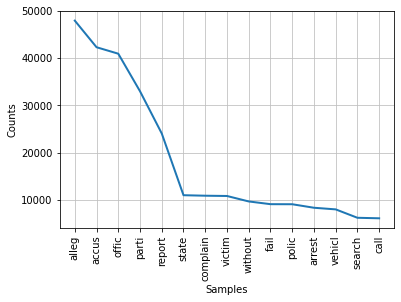

In [ ]:
#@title Word Frequency
word_freq = nltk.FreqDist(filtered_tokens)
word_freq.plot(15)

In [ ]:
#@title Top 20 frequent words
print('Top 20 Most Frequent Words')
word_freq.most_common(20)

Top 20 Most Frequent Words


[('alleg', 47932),
 ('accus', 42306),
 ('offic', 40937),
 ('parti', 32996),
 ('report', 24072),
 ('state', 11018),
 ('complain', 10912),
 ('victim', 10854),
 ('without', 9701),
 ('fail', 9123),
 ('polic', 9109),
 ('arrest', 8367),
 ('vehicl', 8023),
 ('search', 6247),
 ('call', 6138),
 ('``', 5836),
 ('stop', 4864),
 ('justif', 4839),
 ('male', 4526),
 ('refus', 4156)]

In [ ]:
#@title LDA
#%%capture
# evaluate with LDA model
#NOTE: LDA_MODEL TAKES 6 MINUTES TO RUN
lda_model = LdaModel(corpus=corpus,id2word=id2word,num_topics=10, random_state=0,chunksize=100,alpha='auto',per_word_topics=True)

# uncomment to display progress
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
#@title Interactive PCA graph
# display lda model on 2d principle components
pyLDAvis.enable_notebook()
p = gensim.prepare(lda_model, corpus, id2word)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.186280 -0.177181       1        1  11.534033
5      0.118624 -0.061376       2        1  10.421084
7     -0.003717  0.084066       3        1  10.229371
0     -0.023467 -0.073660       4        1   9.927078
9      0.069490  0.108703       5        1   9.857651
1      0.097290 -0.049725       6        1   9.834859
2     -0.009982  0.009435       7        1   9.726659
3     -0.088348  0.364609       8        1   9.531376
6     -0.393111 -0.177427       9        1   9.471540
8      0.046941 -0.027445      10        1   9.466349, topic_info=           Term          Freq         Total Category  logprob  loglift
1199      alleg  46661.000000  46661.000000  Default  30.0000  30.0000
762       accus  46336.000000  46336.000000  Default  29.0000  29.0000
13343     offic  40660.000000  40660.000000  Default  28.0000  28.0000
13917     parti  34552.000000  34552.000000  Default  27.0000  27.0000
15791    report  21834.000000  21834.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
17721     speak    609.909494    610.782492  Topic10  -4.8388   2.3560
1749        arm    579.316705    580.189703  Topic10  -4.8902   2.3559
9479   individu    529.954092    530.827090  Topic10  -4.9793   2.3558
12409  motorist    518.713594    519.586592  Topic10  -5.0007   2.3557
1480     anonym    490.888856    491.761856  Topic10  -5.0559   2.3557

[334 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
0          8  0.999624      ''
604        8  0.999769      ``
664        5  0.994419  abrupt
676        6  0.999055    abus
713        8  0.999221   accid
...      ...       ...     ...
21324      3  0.999260   would
21359     10  0.998888   wrong
21364     10  0.999302   wrote
21474      8  0.999650    year
21483      2  0.999556    yell

[306 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 8, 1, 10, 2, 3, 4, 7, 9])

**PCA ANALYSIS**

The PCA tool was utilised since the high level view of frequent words do not give much insight. 


1. PCA 1-3 displays aggressive, unprofessional behavior of the accused.
2. PCA 4-6 displays misconduct in terms of procedure highlighted by the frequent appearance of words like 'false', 'ignore', 'harrass', 'inappropriate','supervisor' 
3. PCA 6-10 displays a lot of rude verbal abuse and unprofessional conduct including profanities.

**Some topic wise analysis:**


1.  PCA 1,2 seems to be centered around domestic violence cases and cases against black civilians with a failure of appropriate response from officers
2.   PCA 3 seems to be centered around stopping vehicles without probable cause and conversations seem to have been terse bordering on rude.

In [ ]:
#@title
#Generate bigrams and trigrams
def generate_ngrams(text, n):
    ngrams = zip(*[text[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

bigram_freq = {}
for i in range(len(filtered_tokens)-1):
    bigram = (filtered_tokens[i],  filtered_tokens[i+1])
    if bigram not in bigram_freq:
        bigram_freq[bigram] = 0
    bigram_freq[bigram] += 1
        
trigram_freq = {}
for i in range(len(filtered_tokens)-2):
    trigram = (filtered_tokens[i],  filtered_tokens[i+1], filtered_tokens[i+2])
    if trigram not in trigram_freq:
        trigram_freq[trigram] = 0
    trigram_freq[trigram] += 1
# bigrams = generate_ngrams(list(filtered_tokens), 2)
# trigrams = generate_ngrams(list(filtered_tokens), 3)
print("Total corpa: ",len(filtered_tokens))
print("Total bigrams: ",len(bigram_freq))
print("Total trigrams: ",len(trigram_freq))

Total corpa:  813843
Total bigrams:  150450
Total trigrams:  280934


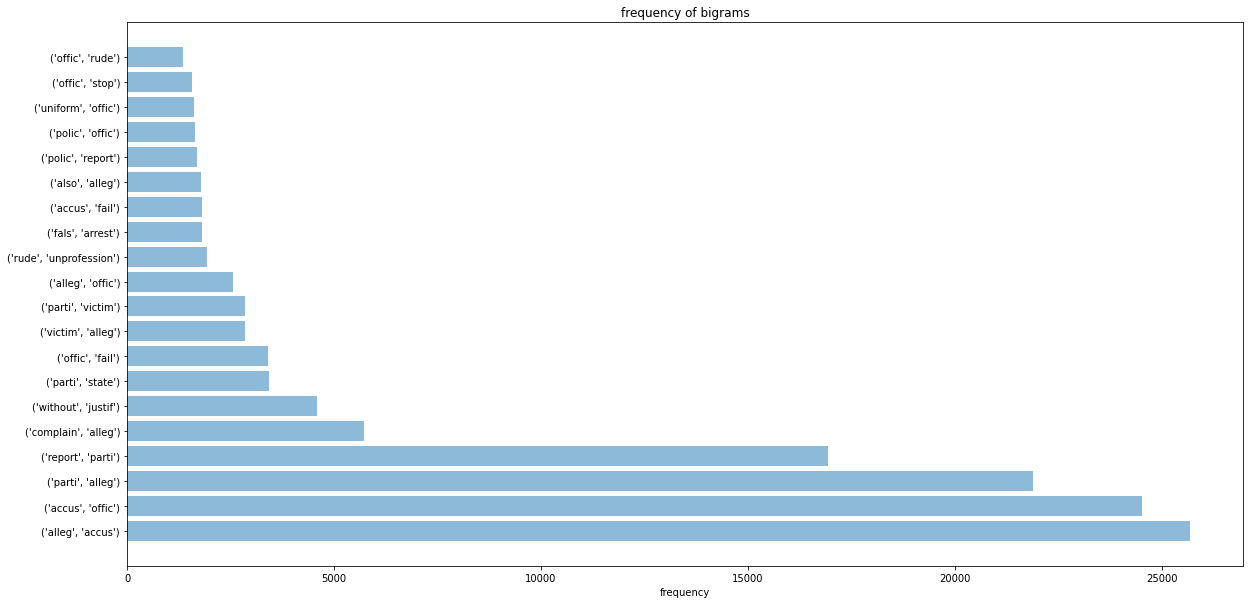

In [ ]:
#@title Bigram frequencies
#Plot bigram frequencies
sorted_bigram_freq = sorted(bigram_freq.items(), key=lambda v: v[1], reverse = True)
phrases = []
freq = []
for x in range(len(sorted_bigram_freq)):
    phrases.append(sorted_bigram_freq[x][0])
    freq.append(sorted_bigram_freq[x][1])
phrases = phrases[:20]
freq = freq[:20]
y_pos = np.arange(len(phrases))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.barh(y_pos, freq, align='center', alpha=0.5)
plt.yticks(y_pos, phrases)
plt.xlabel('frequency')
plt.title('frequency of bigrams')
plt.show()

**Ignoring common words that appear on all reports like alleged, accused, complaint, report etc. we can see the bigrams like "offic,rude","fals,arrest","without,justif" are all indicative of unproffessional and improper conduct with civilians and callousness towards procedure.**

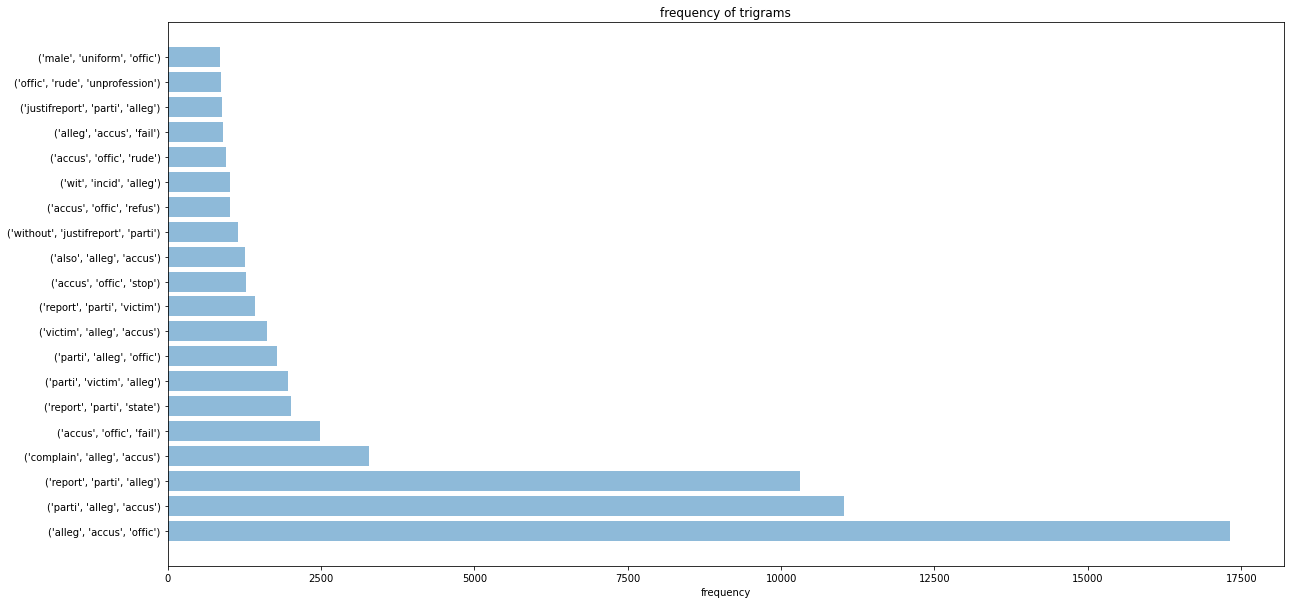

In [ ]:
#@title Trigram frequencies
#Plot trigram frequencies
sorted_trigram_freq = sorted(trigram_freq.items(), key=lambda v: v[1], reverse = True)
phrases = []
freq = []
for x in range(len(sorted_trigram_freq)):
    phrases.append(sorted_trigram_freq[x][0])
    freq.append(sorted_trigram_freq[x][1])

# toggle which phrases to analyze
phrases = phrases[:20]
freq = freq[:20]
y_pos = np.arange(len(phrases))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.barh(y_pos, freq, align='center', alpha=0.5)
plt.yticks(y_pos, phrases)
plt.xlabel('frequency')
plt.title('frequency of trigrams')
plt.show()

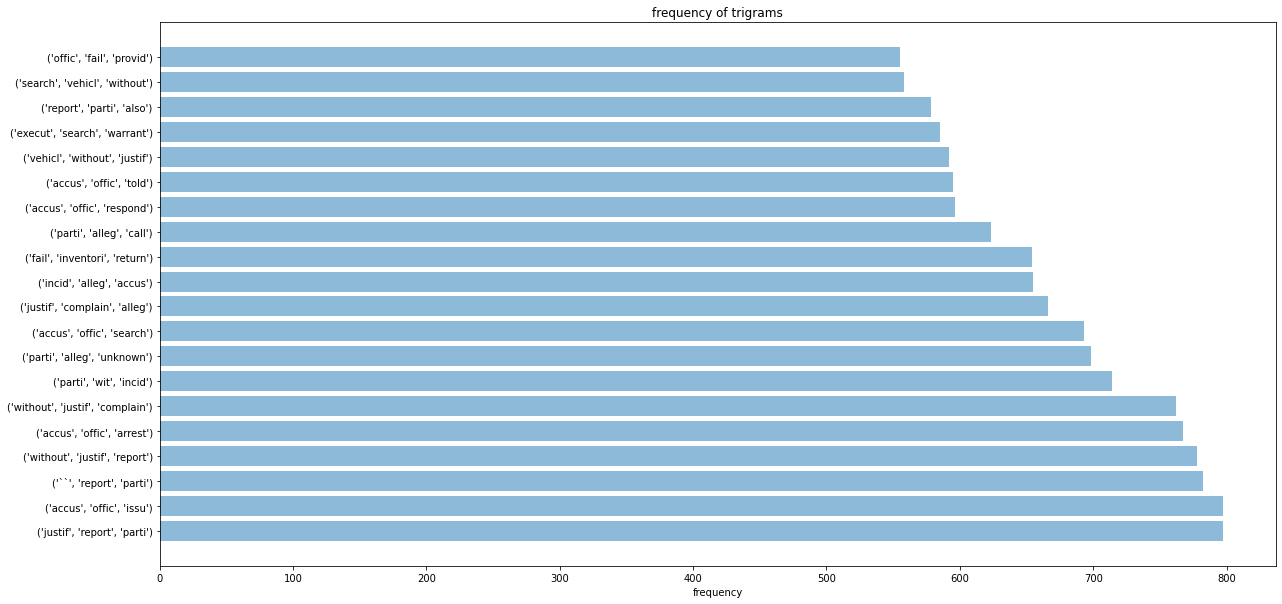

In [ ]:
#@title Trigram frequency continued...
#Plot trigram frequencies
sorted_trigram_freq = sorted(trigram_freq.items(), key=lambda v: v[1], reverse = True)
phrases = []
freq = []
for x in range(len(sorted_trigram_freq)):
    phrases.append(sorted_trigram_freq[x][0])
    freq.append(sorted_trigram_freq[x][1])

# toggle which phrases to analyze
phrases = phrases[20:40]
freq = freq[20:40]
y_pos = np.arange(len(phrases))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.barh(y_pos, freq, align='center', alpha=0.5)
plt.yticks(y_pos, phrases)
plt.xlabel('frequency')
plt.title('frequency of trigrams')
plt.show()

**The trigrams "search,vehicl,without","vehic,without,justif","fail,inventori,return","without,justif,complain" all support the findings from bigrams indicating lack of attentiveness bordering on complete disregard of procedure.**

## **FOR DATA ALLEGATION TABLE**

**Getting data and converting to dataframe**

In [ ]:
#@title
allegation="select crid,summary,substring(cast(incident_date as text),0,11) as incident_date, is_officer_complaint,location from data_allegation where data_allegation.summary != ''"

#converting to a dataframe
cursor.execute(allegation)
allegation_n = cursor.fetchall()
print("shape is: " + str(len(allegation_n)))

df_allegation = pd.DataFrame(allegation_n)
colnames = [desc[0] for desc in cursor.description]
df_allegation.columns = colnames

#dropping null entries of start date
#df_allegation=df_allegation.dropna(subset=['incident_date'])

print(df_allegation.shape)

shape is: 1147
(1147, 5)


In [ ]:
#@title
df_allegation['incident_date']= pd.to_datetime(df_allegation['incident_date'])

In [ ]:
#@title Checking our dataframe output
print(df_allegation.head())

      crid                                            summary incident_date  \
0  1049123  In an incident involving three on-duty CPD mem...    2011-10-05   
1  1049179  On October 10th, 2011, a complaint was registe...    2011-10-08   
2  1049208  In an incident involving an on-duty Lieutenant...    2011-10-10   
3  1049273  On October 13, 2011, a complaint was registere...    2011-10-12   
4  1049571  On October 25, 2011, a complaint was registere...    2011-10-24   

   is_officer_complaint            location  
0                 False   Private Residence  
1                  True                  XX  
2                 False          Restaurant  
3                  True  Public Way - Other  
4                 False   Private Residence  


**Applying pre processing to clean text with Text Hero**

In [ ]:
#@title
def cleaner(df):
    pipeline = [pp.fillna
                , pp.remove_digits
                , pp.lowercase
                , pp.remove_punctuation
                , pp.remove_diacritics
                , pp.remove_stopwords
                , pp.remove_whitespace
                , pp.stem
                ]
    df['summary'] = hero.clean(df['summary'], pipeline=pipeline)
    return df
df_clean = cleaner(df_allegation)

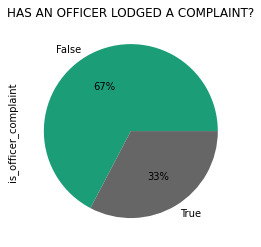

In [ ]:
#@title
#Plotting the officer lodged complaint types
p=df_clean.is_officer_complaint.value_counts()
p.plot(kind='pie', autopct='%1.0f%%',title='HAS AN OFFICER LODGED A COMPLAINT?', colormap='Dark2')

**NOTE: About 67% of the data used are complaints made by civilians and 33% made by fellow officers**

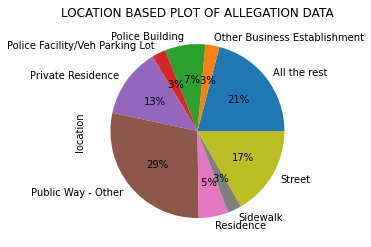

In [ ]:
#@title
#Plotting the location types
p=df_clean['location'].value_counts()

#Grouping smaller counts as other locations
plot_p=p.groupby(np.where(p>=30,p.index,'All the rest')).sum()

plot_p.plot(kind='pie', autopct='%2.0f%%',title='LOCATION BASED PLOT OF ALLEGATION DATA')

**Apply sentiment analysis to cleaned data with Vader**

In [ ]:
#@title
df = df_clean
df['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df['summary']]
df['neg'] = [analyzer.polarity_scores(v)['neg'] for v in df['summary']]
df['neu'] = [analyzer.polarity_scores(v)['neu'] for v in df['summary']]
df['pos'] = [analyzer.polarity_scores(v)['pos'] for v in df['summary']]
print(df.head(2))

      crid                                            summary incident_date  \
0  1049123  incid involv three duti cpd member includ two ...    2011-10-05   
1  1049179  octob 10th complaint regist independ polic rev...    2011-10-08   

   is_officer_complaint           location  compound    neg    neu    pos  
0                 False  Private Residence   -0.9744  0.419  0.581  0.000  
1                  True                 XX   -0.9313  0.203  0.746  0.051  


**Time Series complaint analysis from incident date**

In [ ]:
#@title
#to set the datetime for plotting
from datetime import datetime
time_now = datetime.now()

import pytz

               100_neg   100_pos   100_neu  100_compound
incident_date                                           
2010-01-26      0.1080  0.141000  0.752000      0.718400
2016-02-25      0.0615  0.094000  0.845000      0.495800
2016-07-01      0.0580  0.077333  0.865333      0.224467
2014-03-25      0.0985  0.058000  0.844000      0.049175
2015-07-29      0.1236  0.058400  0.818400     -0.106040


<Figure size 432x288 with 0 Axes>

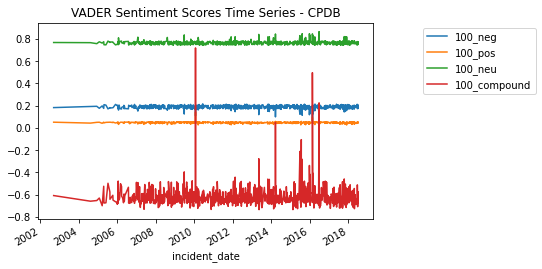

In [ ]:
#@title
df_timeseries = df[['incident_date', 'compound', 'neg', 'neu', 'pos']].copy()
df_timeseries = df_timeseries.sample(n=1000, random_state=42)
df_timeseries.set_index('incident_date', inplace=True)

df_timeseries['100_neg'] = df_timeseries.neg.rolling(100, min_periods=1).mean()
df_timeseries['100_pos'] = df_timeseries.pos.rolling(100, min_periods=1).mean()
df_timeseries['100_neu'] = df_timeseries.neu.rolling(100, min_periods=1).mean()
df_timeseries['100_compound'] = df_timeseries.compound.rolling(100, min_periods=1).mean()
df_plot=df_timeseries[['100_neg','100_pos', '100_neu', '100_compound']]
print(df_plot.head())

plt.figure()
df_plot.plot(title='VADER Sentiment Scores Time Series - CPDB', legend=False)
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))
plt.show()

**NOTE: This table has data pre and post major reforms**
The random spikes in compound scores towards positive value encourage further analysis. To understand the effects of reform on these spikes, we split the data to pre and post major reforms using incident_date.

**Pre Major reform and Post major reform analysis ( pre and post 2016 )**

>The text content in the table data_allegation is from the CPD perspective which gives us a better understanding of sentiment within the police force pre-reform and post-reform. Understanding this will allow us to obtain inferences on how receptive was the CPD of reforms and the effectiveness of reform.

In [ ]:
#@title
#Creating PRE and POST COPA dataframes
df_pre=df[df['incident_date']>='2016']
print("Pre COPA data:")
print(df_pre.head())
df_post=df[(df['incident_date']<'2016') & (df['incident_date']>='2013')]
print("\n Post COPA data:")
print(df_post.head())

Pre COPA data:
        crid                                            summary incident_date  \
112  1078866  januari chicago polic depart cpd member assist...    2016-01-12   
113  1078888  januari chicago polic offic respond report thr...    2016-01-15   
114  1079748  incid involv offic b c alleg offic b c enter s...    2016-03-20   
115  1079542  complain itter walk street view chicago polic ...    2016-03-06   
116  1079908  complain alleg offic sit vehicl remov taser pl...    2016-03-31   

     is_officer_complaint            location  compound    neg    neu    pos  
112                 False  Public Way - Other   -0.9260  0.104  0.808  0.088  
113                  True       Bar Or Tavern   -0.5267  0.159  0.841  0.000  
114                 False           Residence    0.0000  0.000  1.000  0.000  
115                 False  Public Way - Other   -0.3612  0.185  0.815  0.000  
116                  True              Street   -0.6369  0.157  0.843  0.000  

 Post COPA data:
      

**Pre major reforms sentiment analysis**

                 20_neg   20_pos    20_neu  20_compound
incident_date                                          
2013-04-11     0.104000  0.05700  0.839000     -0.32910
2013-04-24     0.176500  0.02850  0.795000     -0.53605
2013-04-18     0.155667  0.03300  0.811333     -0.52200
2013-05-01     0.171500  0.02475  0.803750     -0.56170
2013-01-28     0.137200  0.01980  0.843000     -0.44936


<Figure size 432x288 with 0 Axes>

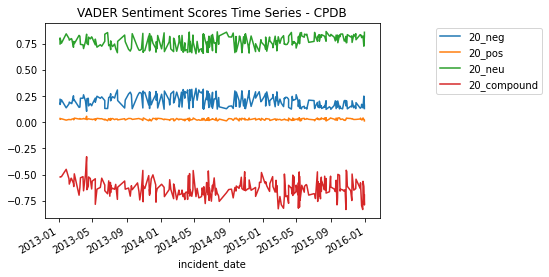

In [ ]:
#@title
df = df_post
df_timeseries = df[['incident_date', 'compound', 'neg', 'neu', 'pos']].copy()
df_timeseries.set_index('incident_date', inplace=True)

df_timeseries['20_neg'] = df_timeseries.neg.rolling(20, min_periods=1).mean()
df_timeseries['20_pos'] = df_timeseries.pos.rolling(20, min_periods=1).mean()
df_timeseries['20_neu'] = df_timeseries.neu.rolling(20, min_periods=1).mean()
df_timeseries['20_compound'] = df_timeseries.compound.rolling(20, min_periods=1).mean()
df_plot=df_timeseries[['20_neg','20_pos', '20_neu', '20_compound']]
print(df_plot.head())

plt.figure()
df_plot.plot(title='VADER Sentiment Scores Time Series - CPDB', legend=False)
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))
plt.show()

**Pre major reform Analysis**
> The range of compound score lies between (-0.25, -0.80). Standalone, this data displays a pretty negative atmosphere. There are also high neutral scores generic of reports. This data combined with future data provides a better perspective. COPA and enforcement of TRR were initiated in 2016 and we want to see whether it was received well. If it was received well the compound scores should increase tending closer to +1.

                 20_neg    20_pos  20_neu  20_compound
incident_date                                         
2016-01-12     0.104000  0.088000  0.8080    -0.926000
2016-01-15     0.131500  0.044000  0.8245    -0.726350
2016-03-20     0.087667  0.029333  0.8830    -0.484233
2016-03-06     0.112000  0.022000  0.8660    -0.453475
2016-03-31     0.121000  0.017600  0.8614    -0.490160


<Figure size 432x288 with 0 Axes>

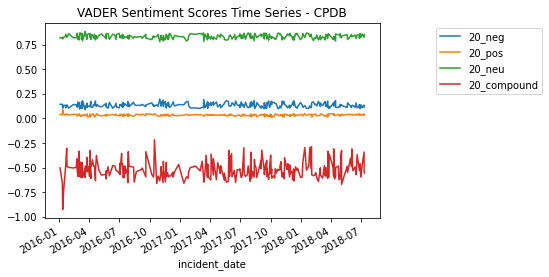

In [ ]:
#@title Post major reform analysis

df = df_pre
df_timeseries = df[['incident_date', 'compound', 'neg', 'neu', 'pos']].copy()
df_timeseries.set_index('incident_date', inplace=True)

df_timeseries['20_neg'] = df_timeseries.neg.rolling(20, min_periods=1).mean()
df_timeseries['20_pos'] = df_timeseries.pos.rolling(20, min_periods=1).mean()
df_timeseries['20_neu'] = df_timeseries.neu.rolling(20, min_periods=1).mean()
df_timeseries['20_compound'] = df_timeseries.compound.rolling(20, min_periods=1).mean()
df_plot=df_timeseries[['20_neg','20_pos', '20_neu', '20_compound']]
print(df_plot.head())

plt.figure()
df_plot.plot(title='VADER Sentiment Scores Time Series - CPDB', legend=False)
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))
plt.show()

**Post major reform Analysis**

>Contrary to expectations the compound scores are observed to be further negative, going as low as 0.92. The range of the compound score has shifted to (-0.25, -1.0) indicative of excessive negativity.

This highly negative score could be indicative of harsher allegations and tonality of reports. We further look into the words to pick out contributors to this score.

**Evaluating text for checkpoint**

In [ ]:
#@title
print('Prep Tables for NLP Analysis')
# Continue with cleaned data table from initial text hero processing
print(df_clean.head())
# create an object to hold narrative content
narrative_content = ''
for i in range(df_clean.shape[0]):
    if i == 0:
        narrative_content = df_clean['summary'][i]
    else:
        narrative_content = narrative_content+ df_clean['summary'][i]

# tokenize narrative content
tokens = word_tokenize(narrative_content)
# print(len(tokens))

Prep Tables for NLP Analysis
      crid                                            summary incident_date  \
0  1049123  incid involv three duti cpd member includ two ...    2011-10-05   
1  1049179  octob 10th complaint regist independ polic rev...    2011-10-08   
2  1049208  incid involv duti lieuten sergeant unknown off...    2011-10-10   
3  1049273  octob complaint regist independ polic review a...    2011-10-12   
4  1049571  octob complaint regist independ polic review a...    2011-10-24   

   is_officer_complaint            location  compound    neg    neu    pos  
0                 False   Private Residence   -0.9744  0.419  0.581  0.000  
1                  True                  XX   -0.9313  0.203  0.746  0.051  
2                 False          Restaurant   -0.9690  0.237  0.763  0.000  
3                  True  Public Way - Other   -0.4019  0.115  0.828  0.057  
4                 False   Private Residence   -0.8555  0.247  0.703  0.049  


In [ ]:
#@title
# filter tokens
spacy.load('en_core_web_sm')
quotes = spacy.lang.punctuation.LIST_QUOTES
punct = spacy.lang.punctuation.LIST_PUNCT
stop_words = stopwords.words("english")
num=['0','1','2','3','4','5','6','7','8','9','&','-','',"'","--"]
trunc_elements = num + stop_words + punct + quotes
trunc = num + punct + quotes

filtered_tokens = []
for i in tokens:
    if i not in trunc:
        filtered_tokens.append(i)
print('Show Filtered Tokens')
print(filtered_tokens[:50])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.



Show Filtered Tokens
['incid', 'involv', 'three', 'duti', 'cpd', 'member', 'includ', 'two', 'offic', 'b', 'sergeant', 'complain', 'victim', 'alleg', 'execut', 'search', 'warrant', 'offic', 'direct', 'profan', 'complain', 'victim', 'kneed', 'victim', 'back', 'pull', 'hair', 'alleg', 'offic', 'b', 'damag', 'sever', 'piec', 'properti', 'execut', 'search', 'alleg', 'sergeant', 'threaten', 'return', 'resid', 'arrest', 'complain', 'victim', 'file', 'complaint', 'fail', 'regist', 'complaint', 'polic']


In [ ]:
#@title
#filter unique words
unique_words = []
for word in filtered_tokens:
    if word not in unique_words:
        unique_words.append(word)
print('Number of Unique Words')
print(len(unique_words))

Number of Unique Words
4543


In [ ]:
#@title
#evaluate corpus with gensim
id2word = Dictionary([filtered_tokens])
corpus = [id2word.doc2bow([text]) for text in filtered_tokens]

for c in corpus:
    print(c[0])
    if c[0][1] > 1:
        print(c)
    break
print('Shape of Corpus')
print(corpus[:1])

(2102, 1)
Shape of Corpus
[[(2102, 1)]]


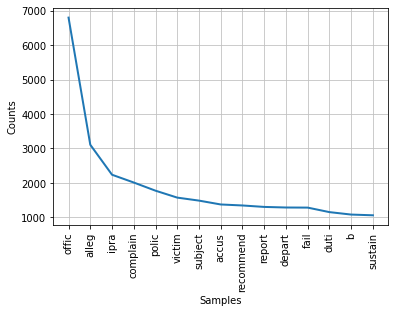

In [ ]:
#@title Word Frequency
word_freq = nltk.FreqDist(filtered_tokens)
word_freq.plot(15)

In [ ]:
#@title 20 most frequent words
print('Top 20 Most Frequent Words')
word_freq.most_common(20)

Top 20 Most Frequent Words


[('offic', 6797),
 ('alleg', 3108),
 ('ipra', 2238),
 ('complain', 2012),
 ('polic', 1775),
 ('victim', 1574),
 ('subject', 1487),
 ('accus', 1375),
 ('recommend', 1346),
 ('report', 1304),
 ('depart', 1287),
 ('fail', 1284),
 ('duti', 1153),
 ('b', 1082),
 ('sustain', 1061),
 ('incid', 840),
 ('chicago', 831),
 ('involv', 803),
 ('sergeant', 802),
 ('vehicl', 754)]

In [ ]:
#@title LDA
#%%capture
# evaluate with LDA model
#NOTE: LDA_MODEL TAKES 6 MINUTES TO RUN
lda_model = LdaModel(corpus=corpus,id2word=id2word,num_topics=10, random_state=0,chunksize=100,alpha='auto',per_word_topics=True)

# uncomment to display progress
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
#@title
# display lda model on 2d principle components
pyLDAvis.enable_notebook()
p = gensim.prepare(lda_model, corpus, id2word)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.119608 -0.292191       1        1  30.651102
6     -0.434886 -0.085931       2        1  10.118821
3      0.028721  0.069643       3        1   7.919733
9      0.024586  0.101189       4        1   7.678596
2      0.062410 -0.058614       5        1   7.646313
4      0.021604  0.137144       6        1   7.348907
0      0.074757 -0.126051       7        1   7.247621
7      0.014033  0.259231       8        1   7.206703
8      0.040153  0.023969       9        1   7.197914
5      0.049015 -0.028389      10        1   6.984290, topic_info=           Term         Freq        Total Category  logprob  loglift
2825      offic  7718.000000  7718.000000  Default  30.0000  30.0000
3879    subject  3614.000000  3614.000000  Default  29.0000  29.0000
3072      polic  1505.000000  1505.000000  Default  28.0000  28.0000
234       alleg  1176.000000  1176.000000  Default  27.0000  27.0000
854    civilian  1116.000000  1116.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1154       dead   103.328995   104.220869  Topic10  -4.3398   2.6529
3342       rent    81.692193    82.593288  Topic10  -4.5747   2.6505
2923  oversight    80.260981    81.152858  Topic10  -4.5924   2.6505
912        come    78.161007    79.052886  Topic10  -4.6189   2.6502
1132       date    77.514054    78.405929  Topic10  -4.6272   2.6501

[330 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
146       7  0.996034   accord
147       1  0.996367  account
179       6  0.988445    admit
201       5  0.990882    agenc
205       8  0.993003   aggrav
...     ...       ...      ...
4436      1  0.996565   weapon
4457      4  0.988845     west
4465      2  0.989309    white
4480      1  0.996685      wit
4505      6  0.994795    would

[301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 4, 10, 3, 5, 1, 8, 9, 6])

**PCA Analysis**

All PCA topics in general seem to indicate excessive violence with frequent words being strike, discharge, head, foot, offend, alterc, control, punch, knee, gun, knife etc.


 

In [ ]:
#@title
#Generate bigrams and trigrams
def generate_ngrams(text, n):
    ngrams = zip(*[text[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

bigram_freq = {}
for i in range(len(filtered_tokens)-1):
    bigram = (filtered_tokens[i],  filtered_tokens[i+1])
    if bigram not in bigram_freq:
        bigram_freq[bigram] = 0
    bigram_freq[bigram] += 1
        
trigram_freq = {}
for i in range(len(filtered_tokens)-2):
    trigram = (filtered_tokens[i],  filtered_tokens[i+1], filtered_tokens[i+2])
    if trigram not in trigram_freq:
        trigram_freq[trigram] = 0
    trigram_freq[trigram] += 1
# bigrams = generate_ngrams(list(filtered_tokens), 2)
# trigrams = generate_ngrams(list(filtered_tokens), 3)
print("Total corpa: ",len(filtered_tokens))
print("Total bigrams: ",len(bigram_freq))
print("Total trigrams: ",len(trigram_freq))

Total corpa:  113459
Total bigrams:  39456
Total trigrams:  65917


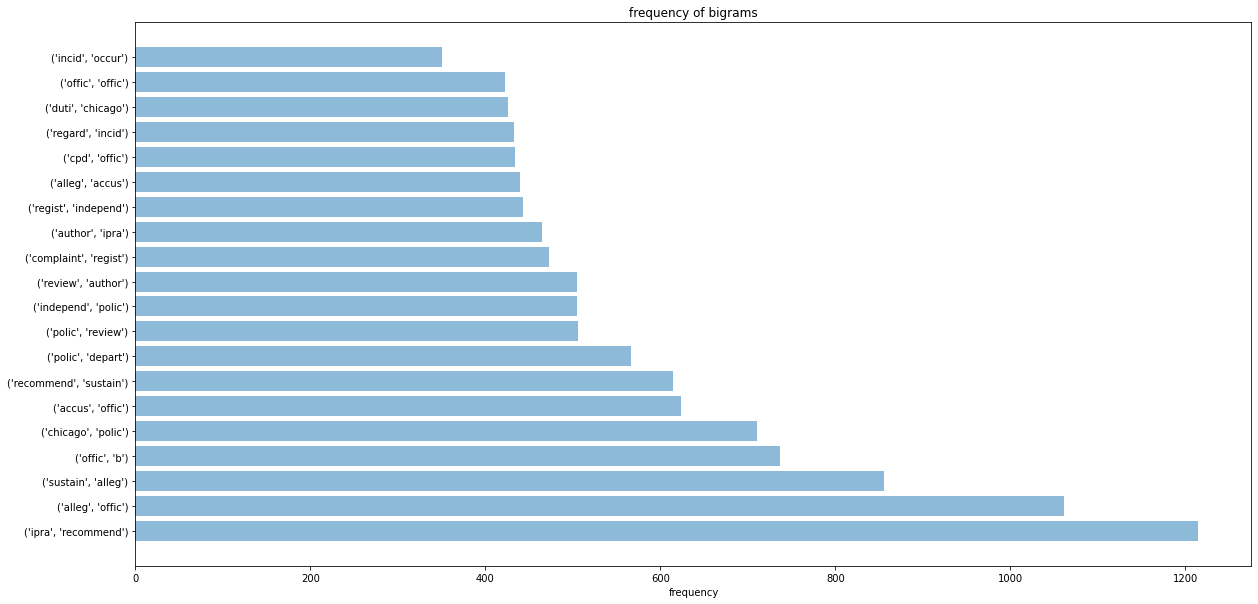

In [ ]:
#@title Bigram frequencies
#Plot bigram frequencies
sorted_bigram_freq = sorted(bigram_freq.items(), key=lambda v: v[1], reverse = True)
phrases = []
freq = []
for x in range(len(sorted_bigram_freq)):
    phrases.append(sorted_bigram_freq[x][0])
    freq.append(sorted_bigram_freq[x][1])
phrases = phrases[:20]
freq = freq[:20]
y_pos = np.arange(len(phrases))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.barh(y_pos, freq, align='center', alpha=0.5)
plt.yticks(y_pos, phrases)
plt.xlabel('frequency')
plt.title('frequency of bigrams')
plt.show()

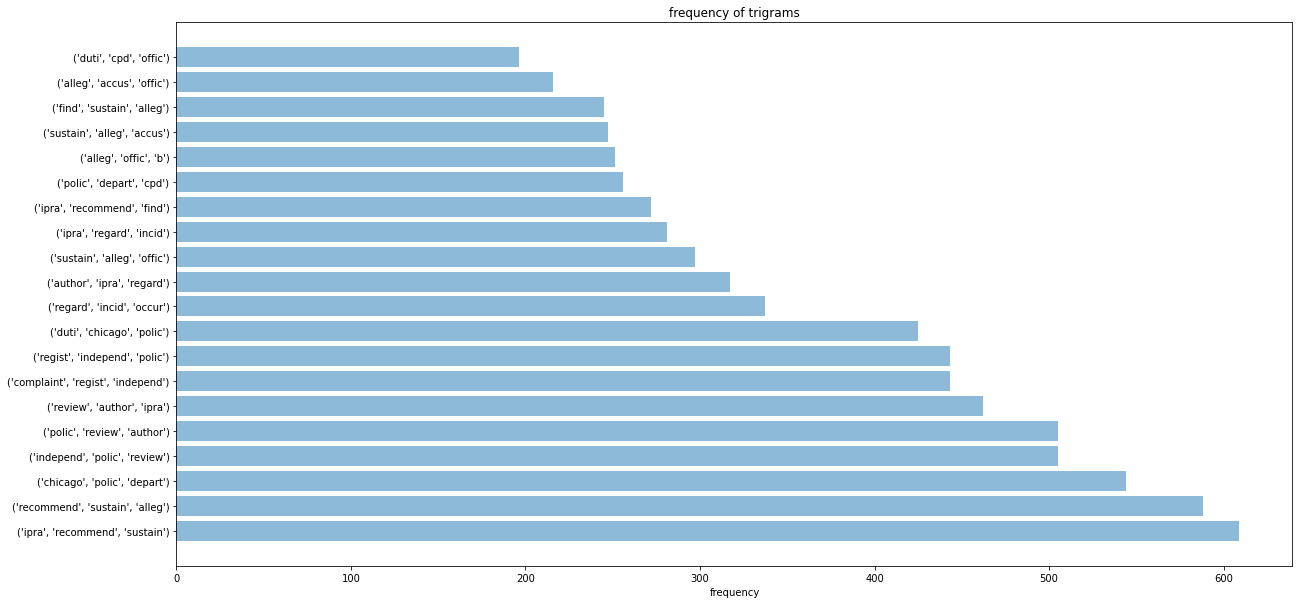

In [ ]:
#@title Trigram Frequencies
#Plot trigram frequencies
sorted_trigram_freq = sorted(trigram_freq.items(), key=lambda v: v[1], reverse = True)
phrases = []
freq = []
for x in range(len(sorted_trigram_freq)):
    phrases.append(sorted_trigram_freq[x][0])
    freq.append(sorted_trigram_freq[x][1])

# toggle which phrases to analyze
phrases = phrases[:20]
freq = freq[:20]
y_pos = np.arange(len(phrases))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.barh(y_pos, freq, align='center', alpha=0.5)
plt.yticks(y_pos, phrases)
plt.xlabel('frequency')
plt.title('frequency of trigrams')
plt.show()

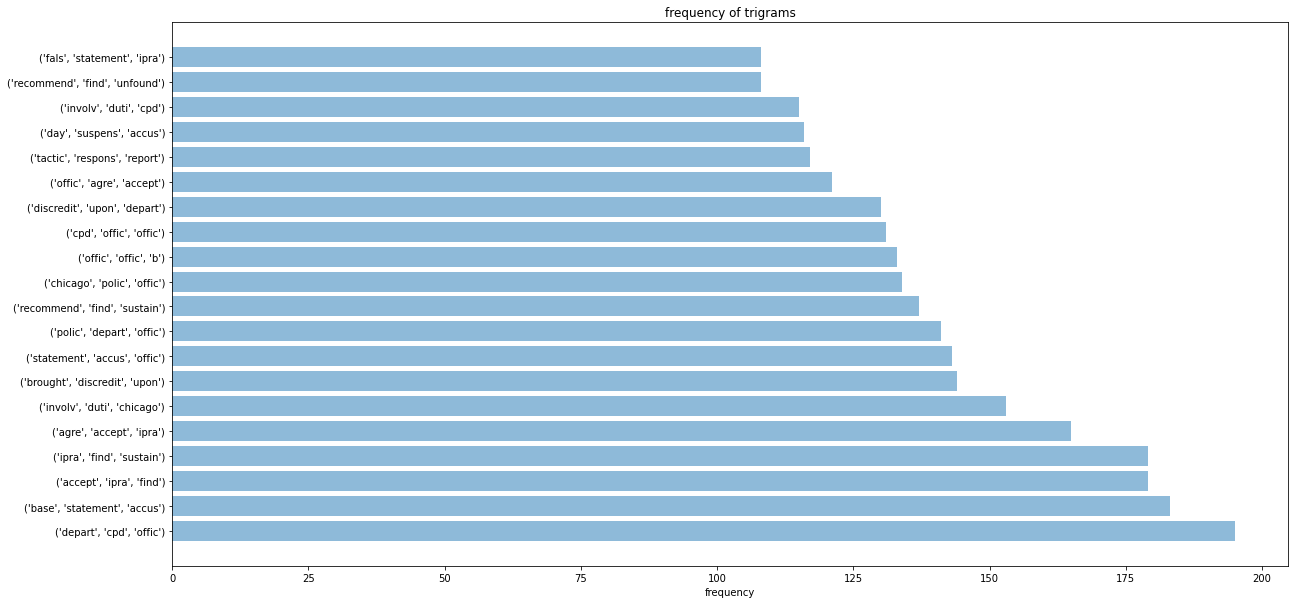

In [ ]:
#@title Trigram Frequencies continued...
#Plot trigram frequencies
sorted_trigram_freq = sorted(trigram_freq.items(), key=lambda v: v[1], reverse = True)
phrases = []
freq = []
for x in range(len(sorted_trigram_freq)):
    phrases.append(sorted_trigram_freq[x][0])
    freq.append(sorted_trigram_freq[x][1])

# toggle which phrases to analyze
phrases = phrases[20:40]
freq = freq[20:40]
y_pos = np.arange(len(phrases))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.barh(y_pos, freq, align='center', alpha=0.5)
plt.yticks(y_pos, phrases)
plt.xlabel('frequency')
plt.title('frequency of trigrams')
plt.show()

**The bigrams and trigrams unlike the previous dataset do not give a lot of insight on the sentiment but it shows clearly the parties involved in all allegations.**

Parties involved
*   CPD
*   IPRA
*   COPA

#**Conclusion**

From this Checkpoint, we can infer that major reforms fostered further negativity due to the prevalence of more reports displaying escalated aggression. We cannot claim the reform completely failed or succeeded due to minimal data post-reform but, the spike in negativity due to reports with escalated aggression could indicate that the reforms fostered more reporting of misconduct. This can be a partial success of the reform. Although, there was barely any downward trend in the negative sentiment. The only success of the reform could be encouraging reporting but not correcting the officers/preventing misconduct.